## MPS function approximation with computation trees

Functions defined through nested or branching algebraic expressions can be efficiently compiled into MPS form by representing their structure as a computation tree. This approach is well suited for functions with reduced support---such as filters or indicator functions---because their MPS representation can be recompressed to a low bond dimension.

Two construction routines are available. The first, `mps_unary_tree`, handles functions with a nested chain-like structure,
$$
F (x_1, x_2, \ldots, x_n) = f \left[ g_1(x_1, \ g_2(x_2, \ \ldots g_{n-1}(x_{n-1}, x_{n})\ldots))\right],
$$
where all node functions $f$ and $\{g_i\}_{i=1}^n$ and domains $\{x_i\}$ are specified beforehand.

The second, `mps_binary_tree`, handles branching expressions,
$$ 
F (x_1, x_2, \ldots, x_n, y_1, y_2, \ldots, y_m) = 
f \left[ g_1(x_1, \ g_2(x_2, \ \ldots g_{n-1}(x_{n-1}, x_{n})\ldots)), \ h_1(y_1, \ h_2(y_2, \ \ldots h_{m-1}(y_{m-1}, y_{m})\ldots)) \right],
$$
with two independent branches that are combined by a final function $f$.


Both algorithms operate by building a computation tree (either `UnaryTree` or `BinaryTree` class) whose internal nodes apply the corresponding functions. Each node (instances of `BranchNode`, with a `UnaryRootNode` or `BinaryRootNode` at the top) evaluates the local function and compresses its values into an MPS core according to the parameters `binning_tol` and `max_rank`, which control value aggregation and the maximum allowed node rank. Propagating these compressed tensors up the tree produces an MPS representation of the full function.


In [23]:
import numpy as np
import matplotlib.pyplot as plt

from seemps.analysis.mesh import RegularInterval
from seemps.analysis.tree import (
    mps_unary_tree,
    mps_binary_tree,
    UnaryTree,
    UnaryRootNode,
    BinaryTree,
    BinaryRootNode,
    BranchNode,
)

Let us illustrate the unary tree algorithm by constructing a two-dimensional Heaviside indicator
$$ F(x_1, x_2; \ c) = \Theta(c - x_1^2 + x_2^2) = \begin{cases} 1 \text{ if } x_1^2 + x_2^2 \leq c \\ 0 \text{ otherwise.} \end{cases} $$

This is given by functions $g_1(x_1) := x_1^2$ and $g_2(x_\mathrm{in}, x_2) := x_\mathrm{in} + x_2^2$, and a combination function $f(x_\mathrm{in}, c) = \Theta(c - x_\mathrm{in})$.

0.0


Text(0.5, 1.0, '$\\Theta(1 - x_1^2 + x_2^2)$')

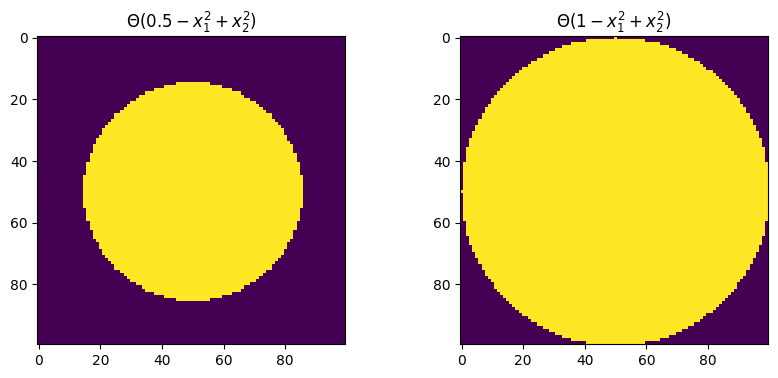

In [24]:
start, stop, N = -1, 1, 100
interval = RegularInterval(start, stop, N)
x = interval.to_vector()

# The boundary node must be also bivariate, but x_in is assumed None.
g1 = BranchNode(lambda x_in, x_s: x_in + x_s**2, grid=x)
g2 = BranchNode(lambda x_in, x_s: x_in + x_s**2, grid=x)
left_nodes = [g1, g2]

c_values = np.linspace(0.5, 1.0, N)
root_node = UnaryRootNode(
	lambda x_in, c: np.heaviside(c - x_in, 1.0),
	grid=c_values,
)

tree = UnaryTree(left_nodes, root_node)
mps = mps_unary_tree(tree, allowed_values=np.array([0.0, 1.0]))
F_mps = mps.to_vector().reshape(N, N, N)

X1, X2 = np.meshgrid(x, x, indexing="ij")
radius2 = X1**2 + X2**2
F_dense = (radius2[..., None] <= c_values[None, None, :]).astype(float)

max_error = np.max(np.abs(F_mps - F_dense))
print(max_error)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(F_mps[:, :, 0])
axes[0].set_title(r"$\Theta(0.5 - x_1^2 + x_2^2)$")
axes[1].imshow(F_mps[:, :, -1])
axes[1].set_title(r"$\Theta(1 - x_1^2 + x_2^2)$")

The binary tree operates in the same manner but considering two branches instead of one, and the recombination function somewhere in the middle of the MPS. For this example, let's consider the simpler function
$$ F(x_1, x_2) = x_1 + x_2 + x_1 x_2 $$
where now $x_1$ and $x_2$ are quantized into bits:
$$ x_i = \sum_{k=1}^{n_i} 2^{-k} s_{ki} .$$

In [37]:
start, stop, n = -1, 1, 6
N = 2**n
interval = RegularInterval(0, 1, N)
x = interval.to_vector()
bit_grid = np.array([0.0, 1.0])

weights = 2.0 ** (-np.arange(1, n+1))

left_nodes = []
for w in weights:
    left_nodes.append(BranchNode(lambda x_in, s, w=w: x_in + w * s, grid=bit_grid))

right_nodes = []
# IMPORTANT: The tensors traverse the opposite direction so we have to invert the weights
for w in reversed(weights): 
    right_nodes.append(BranchNode(lambda x_in, s, w=w: x_in + w * s, grid=bit_grid))

root_node = BinaryRootNode(
    lambda x_L, _, x_R: x_L + x_R + x_L * x_R,
    grid=np.array([0.0])   # dummy grid
)

tree = BinaryTree(left_nodes, root_node, right_nodes)
mps = mps_binary_tree(tree)
F_mps = mps.to_vector().reshape(N, N)

X1, X2 = np.meshgrid(x, x, indexing="ij")
F_dense = X1 + X2 + X1 * X2

max_error = np.max(np.abs(F_mps - F_dense))
print(f"Max error: {max_error}")

Max error: 0.0


More elaborate examples can be constructed with these building blocks.